In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Constants
EXPORT_PATH = "/home/jovyan/stock_data/"
TARGET_COL = "Close_Price"
EXOG_VARS = ["GDP", "Unemployment_Rate", "Federal_Funds_Rate", "VIX"]
N_PREV_QUARTERS = 10
NUM_DATES = 4
SNP_PATH = "S&P500Data.csv"
TOP_N = 5
INVEST_PER_STOCK = 10

In [ ]:
# Load and prepare S&P 500 data globally
SnP_raw = pd.read_csv(SNP_PATH, parse_dates=["DATE"])
SnP_raw = SnP_raw[["DATE", "Close_Price"]]
SnP_raw.set_index("DATE", inplace=True)
SnP_quarterly = SnP_raw["Close_Price"].resample("QE").last().ffill()

In [ ]:
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df.set_index("DATE", inplace=True)
    exog_q = df[EXOG_VARS].resample("QE").mean()
    price_q = df[TARGET_COL].resample("QE").last()
    df_q = pd.concat([exog_q, price_q], axis=1)
    return df_q.ffill().dropna(subset=[TARGET_COL])

def prepare_lstm_data(df_q, target_q_end):
    periods = df_q.index.to_period("Q")
    tgt = target_q_end.to_period("Q")
    prev = tgt - 1
    start = prev - (N_PREV_QUARTERS - 1)
    window = pd.period_range(start=start, end=prev, freq="Q")
    train = df_q[periods.isin(window)]

    if len(train) < N_PREV_QUARTERS:
        raise ValueError("Insufficient data for training.")

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(train[EXOG_VARS + [TARGET_COL]])

    X = scaled_data[:, :-1].reshape((1, N_PREV_QUARTERS, len(EXOG_VARS)))
    y_actual = df_q.loc[df_q.index.to_period("Q") == tgt, TARGET_COL].iloc[0]

    return X, scaler, y_actual, train[TARGET_COL].iloc[-1], df_q.loc[df_q.index.to_period("Q") == tgt]

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

def predict_for_quarter(df_q, target_q_end):
    X, scaler, y_actual, old_close, test_row = prepare_lstm_data(df_q, target_q_end)
    y_train = np.array([[test_row[TARGET_COL].values[0]]])
    model = build_lstm_model(X.shape[1:])
    model.fit(X, y_train, epochs=100, verbose=0, callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True)
    ])
    y_pred_scaled = model.predict(X, verbose=0)[0, 0]

    dummy = np.zeros((1, len(EXOG_VARS)+1))
    dummy[0, -1] = y_pred_scaled
    y_pred = scaler.inverse_transform(dummy)[0, -1]

    pred_change = (y_pred - old_close) / old_close
    act_change  = (y_actual - old_close) / old_close

    return (
        y_pred, y_actual,
        pred_change, act_change,
        "Up" if pred_change > 0 else "Down",
        "Up" if act_change  > 0 else "Down",
        old_close
    )

def run_predictions_multiple_dates():
    dates = []
    while len(dates) < NUM_DATES:
        try:
            d = pd.to_datetime(input(f"Enter date {len(dates)+1} (YYYY-MM-DD): "))
            dates.append(d)
        except Exception:
            print("❌ Invalid format. Try again.")

    quarter_ends = [d.to_period("Q").end_time for d in dates]
    tickers = [
        f.rsplit("_",1)[0]
        for f in os.listdir(EXPORT_PATH)
        if f.endswith("_combined.csv") and "_" in f
    ]
    scores = {t: {"correct":0, "total":0} for t in tickers}
    visual_data = []

    for qe in quarter_ends:
        print(f"\n📊 Prediction Results for {qe.date()}:\n")
        results = []

        for ticker in tickers:
            path = os.path.join(EXPORT_PATH, f"{ticker}_combined.csv")
            try:
                df_q = load_and_prepare_data(path)
                fc, nc, pc, ac, pd_dir, ad_dir, prev = predict_for_quarter(df_q, qe)
                results.append({
                    "Ticker": ticker,
                    "Previous_Close": prev,
                    "Predicted_Close": fc,
                    "Actual_Close":    nc,
                    "Predicted_Change_Rate": pc,
                    "Actual_Change_Rate":    ac,
                    "Predicted_Direction":   pd_dir,
                    "Actual_Direction":      ad_dir
                })
                scores[ticker]["total"] += 1
                if pd_dir == ad_dir:
                    scores[ticker]["correct"] += 1
            except Exception as e:
                print(f"⚠️ {ticker} on {qe.date()}: {e}")

        df_res = pd.DataFrame(results).sort_values("Predicted_Change_Rate", ascending=False)
        print("📈 Ranked by Predicted Change Rate:\n")
        print(df_res.to_string(index=False,
                               columns=["Ticker","Previous_Close","Predicted_Close",
                                        "Actual_Close","Predicted_Change_Rate",
                                        "Actual_Change_Rate","Predicted_Direction",
                                        "Actual_Direction"]))

        try:
            prev_q = ((qe.to_period("Q")-1).to_timestamp(how="end")).normalize()
            curr_q = qe.to_period("Q").to_timestamp(how="end").normalize()
            snp_old = SnP_quarterly.loc[prev_q]
            snp_new = SnP_quarterly.loc[curr_q]
            snp_ret = (snp_new - snp_old)/snp_old

            topn = df_res.head(TOP_N)
            if len(topn) == TOP_N:
                actual_vs = []
                for _, row in topn.iterrows():
                    df_q = load_and_prepare_data(
                        os.path.join(EXPORT_PATH, f"{row['Ticker']}_combined.csv")
                    )
                    pc_prev = df_q.loc[df_q.index.to_period("Q")==prev_q.to_period("Q"), TARGET_COL].iloc[-1]
                    pc_new  = df_q.loc[df_q.index.to_period("Q")==curr_q.to_period("Q"), TARGET_COL].iloc[-1]
                    r = (pc_new - pc_prev)/pc_prev
                    actual_vs.append(INVEST_PER_STOCK*(1+r))

                portfolio_val = sum(actual_vs)
                initial = INVEST_PER_STOCK * TOP_N
                snp_val = initial * (1 + snp_ret)

                visual_data.append({
                    "Quarter": qe.date(),
                    "S&P500":  snp_val,
                    f"Top{TOP_N}": portfolio_val
                })

                print(f"\n💼 Investment Comparison for {qe.date()}:")
                print(f"  - S&P500 Return: {snp_ret:.2%} → ${snp_val:.2f}")
                print(f"  - Top {TOP_N} Stocks → ${portfolio_val:.2f}")
                winner = "S&P500" if snp_val > portfolio_val else f"Top {TOP_N} Stocks"
                print(f"🔍 Better Performer: {winner}")
            else:
                print("⚠️ Not enough valid stocks for comparison.")
        except Exception as e:
            print(f"⚠️ Could not compute S&P500 comparison for {qe.date()}: {e}")

    summary = []
    for t, v in scores.items():
        tot = v["total"]
        cor = v["correct"]
        summary.append({
            "Ticker": t,
            "Correct": cor,
            "Total":   tot,
            "Accuracy": cor/tot if tot else np.nan
        })
    df_sum = pd.DataFrame(summary).sort_values("Accuracy", ascending=False)
    print("\n📊 Prediction Accuracy over all dates:\n")
    print(df_sum.to_string(index=False))

    if visual_data:
        dfv = pd.DataFrame(visual_data).set_index("Quarter")
        dfv.plot(kind="bar", figsize=(10,6))
        plt.title("Investment Comparison: S&P500 vs Top Stocks")
        plt.ylabel("Portfolio Value ($)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_sum

Enter date 1 (YYYY-MM-DD):  2021-01-01
Enter date 2 (YYYY-MM-DD):  2020-01-01
Enter date 3 (YYYY-MM-DD):  2019-01-01
Enter date 4 (YYYY-MM-DD):  2018-01-01



📊 Prediction Results for 2021-03-31:



W0000 00:00:1748377463.206395      76 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarnin

/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is no

📈 Ranked by Predicted Change Rate:

Ticker  Previous_Close  Predicted_Close  Actual_Close  Predicted_Change_Rate  Actual_Change_Rate Predicted_Direction Actual_Direction
  REGN      481.778198     48639.526572    471.835724              99.958339           -0.020637                  Up             Down
   TMO      460.939575     34637.793213    451.898071              74.146061           -0.019615                  Up             Down
  BIIB      244.860001     11150.179651    279.750000              44.536958            0.142490                  Up               Up
   UNH      329.785706     13477.306741    351.144379              39.866861            0.064765                  Up               Up
  VRTX      236.339996      9192.670556    214.889999              37.895958           -0.090759                  Up             Down
   DHR      193.571991      6667.139746    196.321732              33.442688            0.014205                  Up               Up
  ISRG      272.700012    

/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is no

📈 Ranked by Predicted Change Rate:

Ticker  Previous_Close  Predicted_Close  Actual_Close  Predicted_Change_Rate  Actual_Change_Rate Predicted_Direction Actual_Direction
  REGN      374.444946     23271.592876    486.943939              61.149571            0.300442                  Up               Up
  BIIB      296.730011     12480.463710    316.380005              41.059998            0.066222                  Up               Up
   TMO      320.721558     13081.621214    280.195312              39.788095           -0.126360                  Up             Down
  ISRG      197.050003      4684.627853    165.070007              22.773802           -0.162294                  Up             Down
   UNH      271.987885      6222.291957    231.723724              21.877092           -0.148037                  Up             Down
  VRTX      218.949997      4834.304874    237.949997              21.079493            0.086778                  Up               Up
   LLY      122.720924    

/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is no

📈 Ranked by Predicted Change Rate:

Ticker  Previous_Close  Predicted_Close  Actual_Close  Predicted_Change_Rate  Actual_Change_Rate Predicted_Direction Actual_Direction
  REGN      372.470398     18197.669015    409.488037              47.856685            0.099384                  Up               Up
  ISRG      159.639999      7251.833041    190.193329              44.426166            0.191389                  Up               Up
  VRTX      165.710007      6767.371708    183.949997              39.838642            0.110072                  Up               Up
   UNH      226.650757      8709.520503    225.817154              37.427052           -0.003678                  Up             Down
   TMO      220.351501      8448.736691    269.712311              37.342088            0.224009                  Up               Up
    CI      176.372925      3775.393043    149.385147              20.405740           -0.153015                  Up             Down
  BIIB      300.920013    

/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/jovyan/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is no

📈 Ranked by Predicted Change Rate:

Ticker  Previous_Close  Predicted_Close  Actual_Close  Predicted_Change_Rate  Actual_Change_Rate Predicted_Direction Actual_Direction
  REGN      374.923584     21827.695978    343.410675              57.219053           -0.084052                  Up             Down
   UNH      197.906876      6063.446461    192.743790              29.637877           -0.026088                  Up             Down
  VRTX      149.860001      4471.935419    162.979996              28.840754            0.087548                  Up               Up
  ISRG      121.646667      3181.746542    137.610001              25.155641            0.131227                  Up               Up
   TMO      186.406631      4464.272276    202.843628              22.949107            0.088178                  Up               Up
  BIIB      318.570007      7090.747348    273.820007              21.258051           -0.140471                  Up             Down
    CI      188.559677    

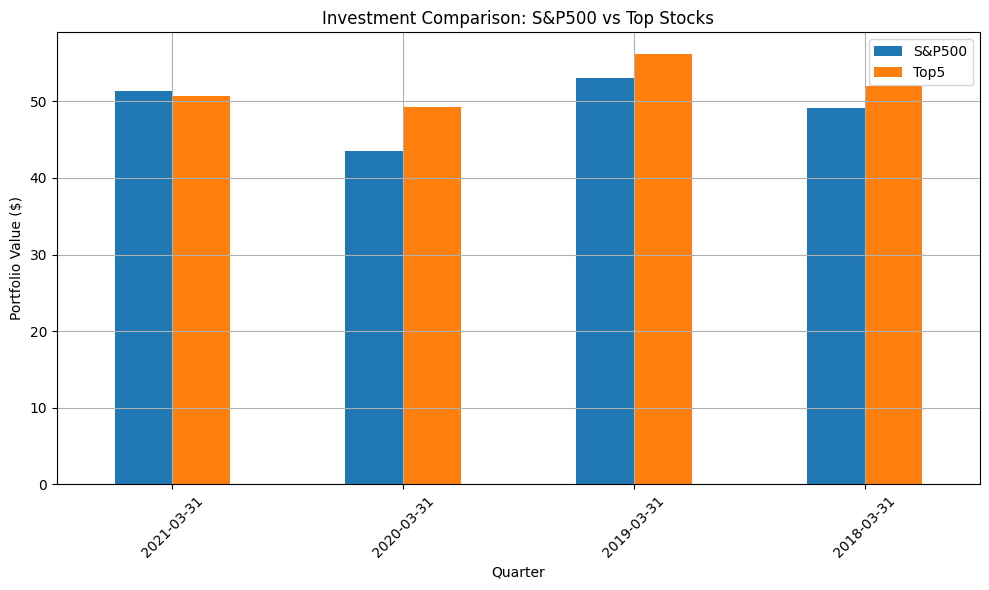

In [ ]:
if __name__ == "__main__":
    run_predictions_multiple_dates()

| Ticker | Correct | Total | Accuracy |
|--------|---------|-------|----------|
| GILD   |       4 |     4 |     1.00 |
| LLY    |       3 |     4 |     0.75 |
| VRTX   |       3 |     4 |     0.75 |
| DHR    |       3 |     4 |     0.75 |
| ABT    |       3 |     4 |     0.75 |
| REGN   |       2 |     4 |     0.50 |
| BMY    |       2 |     4 |     0.50 |
| JNJ    |       2 |     4 |     0.50 |
| MCK    |       2 |     4 |     0.50 |
| ISRG   |       2 |     4 |     0.50 |
